In [1]:
import os
import sys
import pandas as pd

PROJECT_ROOT = "/media/ttoxopeus/basic_UNet"

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
    print(f"✅ Added project root to sys.path:\n   {PROJECT_ROOT}")
else:
    print(f"ℹ️ Project root already in sys.path:\n   {PROJECT_ROOT}")


from src.training.eval import evaluate
from src.models.unet import UNet
from src.pruning.model_inspect import model_to_dataframe_with_l1, get_pruning_masks_blockwise, compute_actual_prune_ratios
from src.pruning.rebuild import rebuild_pruned_unet, find_prev_conv_name

✅ Added project root to sys.path:
   /media/ttoxopeus/basic_UNet


In [2]:
# Create baseline model
model = UNet(in_ch=1, out_ch=4, enc_features=[64, 128, 256, 512])
df = model_to_dataframe_with_l1(model, remove_nan_layers=True)
pd.set_option('display.max_rows', None)
display(df)


🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=64
Encoder 2 : in=64   → out=128
Encoder 3 : in=128  → out=256
Encoder 4 : in=256  → out=512
Bottleneck : in=512  → out=1024
Decoder 1 : skip=512  + up=1024 → out=512
Decoder 2 : skip=256  + up=512  → out=256
Decoder 3 : skip=128  + up=256  → out=128
Decoder 4 : skip=64   + up=128  → out=64
Output conv: 64 → 4



,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0.net.0,Conv2d,"(64, 1, 3, 3)",1.0,64.0,576,1.489326,0.940536,2.586369,0.316829,None,None
1,encoders.0.net.3,Conv2d,"(64, 64, 3, 3)",64.0,64.0,36864,12.002462,11.387016,12.599461,0.282174,None,None
2,encoders.1.net.0,Conv2d,"(128, 64, 3, 3)",64.0,128.0,73728,11.941229,11.169061,12.752104,0.296436,None,None
3,encoders.1.net.3,Conv2d,"(128, 128, 3, 3)",128.0,128.0,147456,16.944456,16.263105,17.506826,0.267103,None,None
4,encoders.2.net.0,Conv2d,"(256, 128, 3, 3)",128.0,256.0,294912,16.974962,16.290926,17.837206,0.275545,None,None
5,encoders.2.net.3,Conv2d,"(256, 256, 3, 3)",256.0,256.0,589824,24.020092,23.273178,24.888638,0.298028,None,None
6,encoders.3.net.0,Conv2d,"(512, 256, 3, 3)",256.0,512.0,1179648,24.004341,23.047682,24.900934,0.266057,None,None
7,encoders.3.net.3,Conv2d,"(512, 512, 3, 3)",512.0,512.0,2359296,33.961658,33.188694,34.739777,0.285611,None,None
8,bottleneck.net.0,Conv2d,"(1024, 512, 3, 3)",512.0,1024.0,4718592,33.932335,33.017345,34.890888,0.293855,None,None
9,bottleneck.net.3,Conv2d,"(1024, 1024, 3, 3)",1024.0,1024.0,9437184,47.997013,47.106525,48.936283,0.281529,None,None


In [ ]:
ratio = 0.25

block_ratios = {
    # --- Encoder DoubleConvs ---
    "encoders.0": 0.2,
    "encoders.1": 0.3,
    "encoders.2": 0.3,
    "encoders.3": 0.3,

    # --- Bottleneck ---
    "bottleneck": 0.3,

    # --- Decoder DoubleConvs only (skip ConvTranspose2d ones) ---
    "decoders.1": 0.3,
    "decoders.3": 0.3,
    "decoders.5": 0.2,
    "decoders.7": 0.1,
}


masks = get_pruning_masks_blockwise(df, block_ratios, default_ratio=0.25)

🔧 Generating pruning masks...

Block encoders.0      | Layer encoders.0.net.0          | ratio=0.20 | threshold=1.2697 | kept 51/64
Block encoders.0      | Layer encoders.0.net.3          | ratio=0.20 | threshold=11.6295 | kept 51/64
Block encoders.1      | Layer encoders.1.net.0          | ratio=0.30 | threshold=11.6440 | kept 89/128
Block encoders.1      | Layer encoders.1.net.3          | ratio=0.30 | threshold=16.6362 | kept 89/128
Block encoders.2      | Layer encoders.2.net.0          | ratio=0.40 | threshold=16.9094 | kept 153/256
Block encoders.2      | Layer encoders.2.net.3          | ratio=0.40 | threshold=23.9194 | kept 153/256
Block encoders.3      | Layer encoders.3.net.0          | ratio=0.50 | threshold=23.9743 | kept 256/512
Block encoders.3      | Layer encoders.3.net.3          | ratio=0.50 | threshold=33.9642 | kept 256/512
Block bottleneck      | Layer bottleneck.net.0          | ratio=0.30 | threshold=33.5794 | kept 717/1024
Block bottleneck      | Layer bottlenec

🔧 Rebuilding pruned UNet architecture...
Encoder features: [51, 89, 153, 256]
Bottleneck out_channels: 717
Decoder features: [307, 179, 102, 57]
Encoder features: [51, 89, 153, 256]
Bottleneck out_channels: 717
Decoder features: [307, 179, 102, 57]

🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=51
Encoder 2 : in=51   → out=89
Encoder 3 : in=89   → out=153
Encoder 4 : in=153  → out=256
Bottleneck : in=256  → out=717
Decoder 1 : skip=256  + up=717  → out=307
Decoder 2 : skip=153  + up=307  → out=179
Decoder 3 : skip=89   + up=179  → out=102
Decoder 4 : skip=51   + up=102  → out=57
Output conv: 57 → 4

✅ Built pruned UNet | enc: [51, 89, 153, 256], dec: [307, 179, 102, 57], bottleneck: 717
✅ Copied weights for encoders.0.net.0 | shape: torch.Size([51, 1, 3, 3])
✅ Copied weights for encoders.0.net.3 | shape: torch.Size([51, 51, 3, 3])
✅ Copied weights for encoders.1.net.0 | shape: torch.Size([89, 51, 3, 3])
✅ Copied weights for encoders.1.net.3 | shape: torch.S

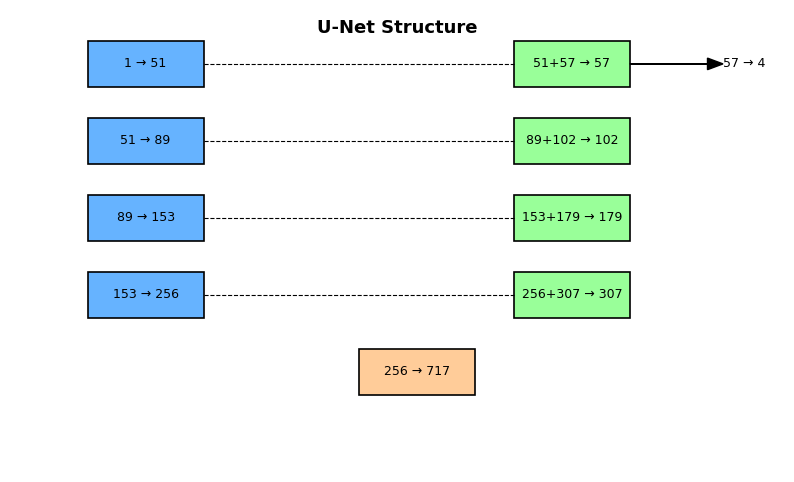

💾 Saved pruned model to /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth
🧾 Saved metadata to: /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model_meta.json
✅ UNet successfully rebuilt.


In [4]:
pruned_model = rebuild_pruned_unet(
    model,
    masks, 
    save_path="/media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth")

In [5]:
post_ratios = compute_actual_prune_ratios(model, pruned_model)


In [6]:
df_pruned = model_to_dataframe_with_l1(
    pruned_model,
    remove_nan_layers=True,
    block_ratios=block_ratios,
    post_prune_ratios=post_ratios
)
display(df_pruned)

,Layer,Type,Shape,In Ch,Out Ch,Num Params,Mean L1,Min L1,Max L1,L1 Std,Block Ratio,Post-Prune Ratio
0,encoders.0.net.0,Conv2d,"(51, 1, 3, 3)",1.0,51.0,459,1.493078,0.940536,2.586369,0.330955,0.2,0.2031
1,encoders.0.net.3,Conv2d,"(51, 51, 3, 3)",51.0,51.0,23409,9.569181,8.946865,9.971607,0.259287,0.2,0.2031
2,encoders.1.net.0,Conv2d,"(89, 51, 3, 3)",51.0,89.0,40851,9.504354,8.772633,10.176351,0.279984,0.3,0.3047
3,encoders.1.net.3,Conv2d,"(89, 89, 3, 3)",89.0,89.0,71289,11.762643,10.951397,12.291181,0.257879,0.3,0.3047
4,encoders.2.net.0,Conv2d,"(153, 89, 3, 3)",89.0,153.0,122553,11.797815,11.161534,12.491564,0.238254,0.4,0.4023
5,encoders.2.net.3,Conv2d,"(153, 153, 3, 3)",153.0,153.0,210681,14.341439,13.558181,14.984001,0.227331,0.4,0.4023
6,encoders.3.net.0,Conv2d,"(256, 153, 3, 3)",153.0,256.0,352512,14.352971,13.765762,15.087887,0.219071,0.5,0.5
7,encoders.3.net.3,Conv2d,"(256, 256, 3, 3)",256.0,256.0,589824,16.990210,16.473831,17.646332,0.210055,0.5,0.5
8,bottleneck.net.0,Conv2d,"(717, 256, 3, 3)",256.0,717.0,1651968,16.959562,16.313400,17.612621,0.200063,0.3,0.2998
9,bottleneck.net.3,Conv2d,"(717, 717, 3, 3)",717.0,717.0,4626801,33.607777,32.929138,34.429256,0.237524,0.3,0.2998


🔍 Evaluating model from: /media/ttoxopeus/basic_UNet/results/UNet_ACDC/exp1/pruned/pruned_model.pth
📂 Saving results to: results/UNet_ACDC/exp1/pruned/evaluation
✅ Loaded 3000 test batches.

🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=51
Encoder 2 : in=51   → out=89
Encoder 3 : in=89   → out=153
Encoder 4 : in=153  → out=256
Bottleneck : in=256  → out=512
Decoder 1 : skip=256  + up=512  → out=256
Decoder 2 : skip=153  + up=256  → out=153
Decoder 3 : skip=89   + up=153  → out=89
Decoder 4 : skip=51   + up=89   → out=51
Output conv: 51 → 4


🧩 U-Net Architecture Summary:
Input channels:  1
Encoder 1 : in=1    → out=51
Encoder 2 : in=51   → out=89
Encoder 3 : in=89   → out=153
Encoder 4 : in=153  → out=256
Bottleneck : in=256  → out=717
Decoder 1 : skip=256  + up=717  → out=307
Decoder 2 : skip=153  + up=307  → out=179
Decoder 3 : skip=89   + up=179  → out=102
Decoder 4 : skip=51   + up=102  → out=57
Output conv: 57 → 4

✅ Built pruned UNet | enc: [51, 89, 1

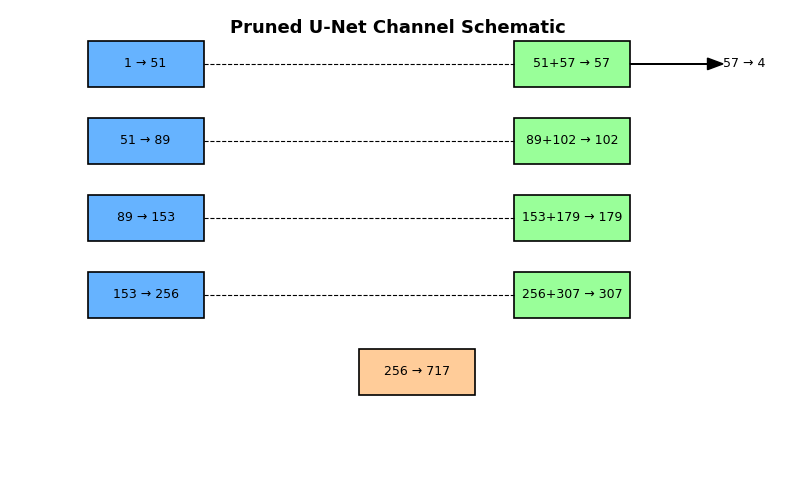

🚀 Running evaluation on test set...


Evaluating: 100%|██████████| 3000/3000 [00:31<00:00, 95.49it/s] 


✅ Evaluation complete!
📊 Mean Dice: 0.4634
📊 Mean IoU:  0.4488
───────────────────────────────
Background    Dice=0.9295  IoU=0.8712
RV            Dice=0.5763  IoU=0.5763
Myocardium    Dice=0.1100  IoU=0.1100
LV            Dice=0.2377  IoU=0.2377
───────────────────────────────
💾 Metrics saved to results/UNet_ACDC/exp1/pruned/evaluation/eval_metrics.json


In [7]:
evaluate()